# **Chap5：注意力机制**

In [34]:
import tensorflow as tf
from matplotlib import pyplot as plt
import numpy as np
from source.code import ch5
from source.code import utils

In [3]:
# 如果你要在服务器上和别人共用GPU，可以设置你需要的显存资源
utils.gpu_limitation_config(memory=4,device=1)

## **5.1 注意力思想**

### **5.1.1 理解注意力**

现实生活中，**注意力是昂贵的**，并且注意力是我们做好一件事的必不可少的部分，现代经济学**直接认为注意力是一种可交换的等价物**：
* 音乐、视频流媒体服务中，人们需要消耗注意力观看广告，或是通过付费跳过 / 隐藏广告
* 游戏中，人们需要消耗注意力在游戏战斗中，提升角色战力，或是通过充值来减少这部分注意力的消耗

注意力又是稀缺的，**环境中充满了各种干然和噪声将有用的、重要的信息淹没**，通过长时间的进化，人们在能够视觉神经系统每秒接收约 $10^8$ 位的信息中通过注意力过滤得到有用的部分，**注意力的这种机制能够将我们的思考（计算）仅集中在输入的一小部分上**，将资源更明智地分配和管理

神经网络科学家们思考，能否**为神经网络引入注意力这种机制**？

**(1) 随意线索和不随意线索**

心理学家威廉·詹姆斯将人的注意力分为**非自主性提示**和**自主性提示**两类，考虑下面的场景

假如我们面前有五个物品： 一份报纸、一篇研究论文、一杯咖啡、一本笔记本和一本书，所有**纸制品都是黑白印刷的，但咖啡杯是红色的**，一般情况下，第一反应你的注意力会看到什么？
* **咖啡杯在这种视觉环境中是突出和显眼的**，因此咖啡杯会吸引你的注意力
* 这种注意力诱发**不由自主地引起人们的注意**，即**非自主性提示**
* 我们也将其称为**不随意线索**（不跟随自主意图的注意力线索）

<img src="../source/Chap5/不随意线索.svg" width=500>

而如果我们是带有目的的观察桌上的物品，例如**我想看书**，这种时候，你的注意力会看到什么？
* 我们会**直接将目标锁定到书本**，即使咖啡杯是耀眼的
* **与突出性导致的选择不同**，此时**选择书是受到了认知和意识的控制**，即**自主性提示**
* **注意力在基于自主性提示去辅助选择时将更为谨慎**
* 我们也将其称为**随意线索**（跟随自主意图的注意力线索）

<img src="../source/Chap5/随意线索.svg" width=500>

接下来，我们尝试将注意力的这种作用过程做**形式化建模**

**(2) 注意力三要素：key, value 和 query**

自主性的与非自主性的注意力提示解释了人类的注意力的方式，我们尝试将这个过程**用神经网络建模**

环境中的每个客体，都可以抽象为一个**键值对**（`key-value pair`）
* 我们**用** `key` **表示非自主性提示，即不随意线索，用来索引客体**，**用** `value` **表示客体，即感官输入**
* 每个 `value` 都与一个 `key` 配对

当我们有一个想法时，**自主性提示**会被视为一个**查询**（`query`）
* 给定任何 `query`，模型的注意力机制通过**注意力汇聚**（**Attention Pooling**）将选择引导至感官输出，即 `value`

于是，人们设计了下图的**注意力机制**
* 通过**设计注意力汇聚层**，将给定的 `query`（**随意线索**）与 `key` （**不随意线索**）进行匹配，以得出最匹配的 `value`
* 这是本章后续所有模型的基础结构，是接下来模型讨论的中心
* 对**注意力的汇聚设计有非常多的方案**

<img src="../source/Chap5/注意力机制.svg" width=700>

注意力机制的这种结构可以被应用到很多模型中，但**在应用上述注意力框架时，最核心的是明确问题中**，**哪些变量作为** `key-value` **对，哪些变量作为** `query`

下面介绍的 **Nadaraya-Watson 核回归注意力** 是最早的也是最简单的注意力机制模型，我们基于此来更具体的说明上面的注意力框架，并明确问题中的 `key, value, query`

### **5.1.2 核回归注意力**

**(1) 生成数据**

我们考虑一个简单的回归问题，给定**输入输出对数据集** $\{(x_i,y_i)\}_{i=1}^{n}$，其中：
$$
y_i = f(x_i) +  \varepsilon_i= 2\sin(x_i) + x_i^{0.8} + \varepsilon_i,\quad \varepsilon_i\sim N(0,0.5^2)
$$

我们思考如果**用注意力的机制来学习这个非线性映射** $f(x_i)$，实现给定任意新的输入 $x$，预测 $y=f(x)$

函数 `generate_regression_data()` 用于生成该回归问题的训练数据集和测试数据集

In [4]:
def generate_regression_data(n_train : int=50, n_test : int=50):
    def f(x):
        return 2*tf.sin(x) + x**0.8
    # 输入特征
    x_train = tf.sort(tf.random.uniform(shape=(n_train, ), maxval=5)) # 训练集特征
    x_test = tf.cast(tf.linspace(0, 5, n_test),dtype=tf.float32) # 测试集特征

    # 标签
    y_train= f(x_train) + tf.random.normal(shape=(n_train, ), stddev=0.5) # 训练集标签
    y_test = f(x_test) # 测试集标签

    return x_train, y_train, x_test, y_test

下面的函数 `plot_kernel_regression()` 用于**绘制数据集和模型的预测效果**

In [5]:
def plot_kernel_regression(x_train, y_train, x_test=None, y_test=None, y_hat=None):
    fig = plt.figure(figsize=(6, 4))
    plt.plot(x_train, y_train, 'o', color="orange", alpha=0.7,label="samples")
    if x_test is not None:
        plt.plot(x_test, y_test, "g-", label="y_test")
    if y_hat is not None:
        plt.plot(x_test, y_hat, "m--", label="y_hat")
    plt.xlabel("$x$"); plt.ylabel("$y$")
    plt.xlim(0, 5); plt.ylim(-1, 5)
    plt.grid()
    plt.legend()

上述两个函数写入了 `../source/code/ch5.py`，我们设置 **80 个训练样本，50 个测试样本**

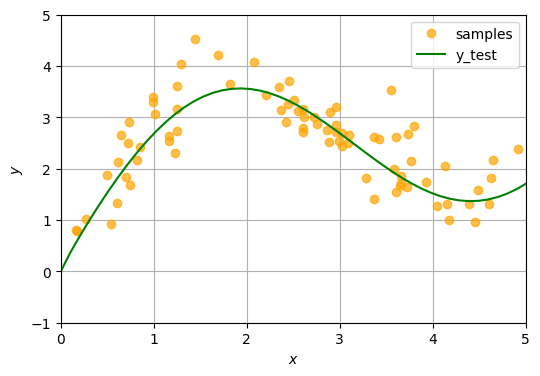

In [7]:
# 生成数据
x_train, y_train, x_test, y_test = ch5.generate_regression_data(n_train=80, n_test=50)
ch5.plot_kernel_regression(x_train, y_train, x_test, y_test)

**(2) 注意力汇聚**

我们将**训练数据中的输入-标签对**视为注意力机制中的 `key-value` 对，即 $x_i$ 作为 `key`（**不随意线索**），$y_i$ 是其对应的 `value`，当**给定一个数据集之外的** `query` $x$ 时（**随意线索**），我们想要预测它的输出 $f(x)$，注意力机制首先依靠**注意力汇聚层**从非随意线索中进行挑选，然后查找得到对应的值

**Nadaraya-Watson核回归**通过考虑 `key`（**不随意线索**） 和 `query`（**随意线索**）之间的距离，设计了如下的注意力汇聚机制：

$$
f(x) = \sum_{i=1}^{n} \frac{K(\|x-x_i\|)}{\sum_{j=1}^{n} K(\|x- x_j\|)} y_i
$$

其中，$K(x)$ 称为**核函数**，受此启发，我们可以将注意力框架写作一个更通用的**注意力汇聚**公式：
$$
\text{AttentionPooling}(x) = \sum_{i=1}^{n} a(x,x_i)y_i
$$

其中，$x$ 是 `query`，$(x_i,y_i)$ 是 `key-value` 对，$a(x,x_i) \in\mathbb{R}$ 是**注意力权重**，负责对不随意线索 `key` 和随意线索 `query` 之间的关系建模，这个权重分配给每一个 `value` $y_i$
* 对于任何 `query` $x$，模型在所有 `key-value` 对注意力权重 $a(x,x_i)$ 都是一个**有效的概率分布**（非负，且总和为 1）
* Nadaraya-Watson核回归使用的注意力权重是：
    $$
    a(x,x_i) = \frac{K(\|x-x_i\|)}{\sum_{j=1}^{n} K(\|x- x_j\|)},\quad i=1,2,\cdots,n
    $$
    即 `query` $x$ 与第 $i$ 个 `key` $x_i$ 的**核函数距离** $K(\|x-x_i\|)$ **占所有核函数距离和的比例**

例如我们考虑带参数的**高斯核**：
$$
K(u;\sigma) = \frac{1}{\sqrt{2\pi}} \exp(-\frac{u^2}{2\sigma^2})
$$

则此时的注意力池化结果为：
$$
f(x) = \sum_{i=1}^{n}a(x,x_i)y_i = \sum_{i=1}^{n} \frac{\exp\left(-\frac{1}{2\sigma^2}(x-x_i)^2\right)}{\sum_{j=1}^{n} \exp\left(-\frac{1}{2\sigma^2}(x-x_j)^2\right)} y_i = \sum_{i=1}^{n} \text{softmax}\left( -\frac{1}{2\sigma^2}(x - x_i)^2 \right)y_i
$$

在高斯核函数下，一个 `key` $x_i$ 越靠近 `query` $x$，它**对应的值** $y_i$ **在注意力分配时就会得到更高的权重**
* 超参数 $\sigma$ 作为超参数，也称为**尺度参数**（scale parameter），可以**控制核函数对距离的缩放尺度**
* 当 $\sigma \to \infty$ 时，对于 `query` $x$，无论距离较近还是较远的 `key` $x_i$， 经过 $\sigma$ 的放缩都会使得：
    $$
    -\frac{1}{2\sigma}(x - x_i)^2 \to 0
    $$
    最后，**注意力汇聚分配给所有** `key` **的权重几乎是相同的**
* 相反，当 $\sigma\to 0$ 时，**只有最靠近** `query` $x$ 的 `key` $x_i$ 才能被分配到注意力，**其他不随意线索的注意力都会趋于 0**

In [8]:
def NadarayaWatson_attention_pooling(key, value, query, sigma : float=1):
    """
    Nadaraya-Watson注意力池化

    Parameters
    ----------
    key : tf.Tensor
        不随意线索，形状为 (n_k,)
    value : tf.Tensor
        不随意线索对应的值，形状为 (n_k,)
    query : tf.Tensor
        需要查询的随意线索，形状为 (n_q,)
    sigma : float, optional
        高斯核的标准差，默认值为 1
    """
    # 将 key 复制 n_q 份，变换形状为 (n_q, n_k) 的矩阵
    key_repeat = tf.repeat(tf.expand_dims(key, axis=0), repeats=query.shape[0], axis=0) # (n_q, n_k)
    
    # 计算注意力权重
    # 利用广播机制，先将 query 的形状变为 (n_q, 1)
    # key_repeat 与 query 广播后，形状变为 (n_q, n_k)
    attn_weights = tf.nn.softmax(-(key_repeat - tf.expand_dims(query, axis=1))**2 / (2*sigma**2), axis=1)

    # 注意力池化
    y_hat = attn_weights @ tf.expand_dims(value, axis=1) # (n_q, n_k) @ (n_k, 1) = (n_q, 1)
    y_hat = tf.squeeze(y_hat, axis=1) # (n_q, 1) -> (n_q,)
    return y_hat, attn_weights

设定超参数 $\sigma = 1$，测试注意力池化在测试集上的表现

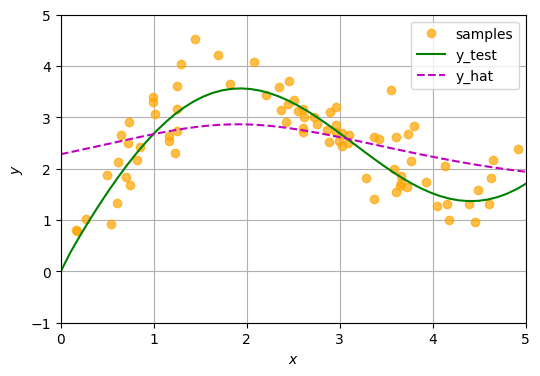

In [35]:
# 利用注意力机制进行预测
y_hat, attn_weights = ch5.NadarayaWatson_attention_pooling(x_train, y_train, x_test, sigma=1)
ch5.plot_kernel_regression(x_train, y_train, x_test, y_test, y_hat)

我们可以定义一个函数 `show_attention()` 来**绘制注意力的分布**
* 该函数已经写入 `../source/code/utils.py`

In [10]:
def show_attention(attn_weights, xlabel, ylabel, titles=None, figsize=(3,3), cmap="Reds"):
    """
    Parameters
    ----------
    attn_weights : tf.Tensor
        注意力权重，形状为 (nrows, ncols, n_q, n_k) \n
        该张量同时保存多个注意力权重，这样可以将每个注意力权重画到一个子图上
    """
    nrows, ncols = attn_weights.shape[0], attn_weights.shape[1]
    # 创建子图
    fig, axes = plt.subplots(nrows, ncols, figsize=figsize,sharex=True,sharey=True,squeeze=False)

    # 依次拿出每一行
    for i, (row_axes, row_weights) in enumerate(zip(axes, attn_weights)):
        # 依次拿出每一列
        for j, (ax, mat) in enumerate(zip(row_axes, row_weights)):
            im = ax.imshow(mat.numpy(), cmap=cmap) # 绘制热力图
            if i == nrows - 1:
                ax.set_xlabel(xlabel) # 设置坐标轴标签
            if j == 0:
                ax.set_ylabel(ylabel) # 设置坐标轴标签
            if titles is not None:
                ax.set_title(titles[j]) # 设置标题
    # 添加图例颜色条
    fig.colorbar(im, ax=axes, shrink=0.6)
    return axes

从注意力分布的图中可以清楚观察到：
* 随着**测试样本从坐标轴左侧移动到右侧**（**图中从上到下**），每个测试样本 $x$ 在 80 个训练样本上（即 80 个不随意线索作为 `key`）的**注意力权重也在坐标轴上不断向右移动**
* 例如**最左侧**靠近 $x = 0$ 的测试样本，**对应图中第一行**，它的**注意力集中在** $x = 0$ **附近的训练集的** `key` 上
* 当 $\sigma = 1$ 时，每个测试样本的**注意力分布宽度大约是 20 ~ 30**

array([[<Axes: xlabel='Keys: Sorted training $x$', ylabel='Queries: Sorted testing $x$'>]],
      dtype=object)

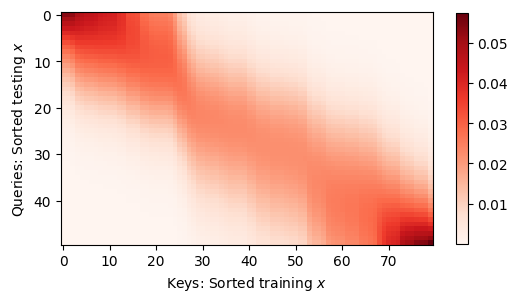

In [12]:
# 绘制注意力权重
utils.show_attention(tf.reshape(attn_weights, shape=(1, 1, *attn_weights.shape)), 
               xlabel="Keys: Sorted training $x$", 
               ylabel="Queries: Sorted testing $x$",figsize=(6,5))

超参数 $\sigma$ 的大小会影响模型的预测效果，**导致模型过拟合或欠拟合**
* 超参数 $\sigma$ 的选择有多种方法，统计上常用交叉验证的方法来确定一个优秀的 $\sigma$

**从神经网络的视角出发**
* 我们可以将参数 $\sigma$ 当作神经网络的可训练模型参数
* 通过**构造损失函数，结合梯度下降**的方法来求得一个合适的 $\sigma$

在此之前我们需要额外介绍一下**批量矩阵乘法**

### **批量矩阵乘法**

在所有深度学习模型的训练过程中，我们的**计算都是基于批量数据讨论的**，因此所有数据都会在 `axis = 0` 上**增加批量维度**
* 现在假设一个小批量数据 $X\in\mathbb{R}^{n\times a\times b}$ 包含 $n$ 个矩阵 $X_1,\cdots,X_n$，形状为 $a\times b$
* 另一个小批量数据 $Y\in\mathbb{R}^{n\times b\times c}$ 包含 $n$ 个矩阵 $Y_1,\cdots,Y_n$，形状为 $b\times c$
* 则 $X,Y$ 可以进行**批量矩阵乘法**，得到 $n$ 个矩阵 $X_1Y_1,\cdots,X_nY_n$，每个形状为 $a\times c$
* 因此假设两个张量的形状分别是 `(n,a,b)` 和 `(n,b,c)`，则它们进行**批量矩阵乘法输出维度** 为 `(n,a,c)`

In [13]:
A, B = tf.ones((2,1,3)), tf.ones((2,3,4))
(A @ B).shape

TensorShape([2, 1, 4])

在注意力机制中，假设批量大小为 $n$ 的一个批量数据中，每个样本包含 $n_q$ 个 `query`，然后有 $n_k=n_v$ 个键值对 `key-value`，则**批量矩阵乘法可以帮助我们计算批量数据中的加权平均值**

In [36]:
batch_size = 2 # 批量大小
n_q, n_k, n_v = 10, 5, 5 # 批量中 query, key, value 的数量

weights = tf.ones((batch_size, n_q),dtype=tf.float32) # 权重形状: (batch_size, n_q)
values = tf.reshape(tf.range(batch_size*n_v,dtype=tf.float32), shape=(batch_size, n_v)) # (batch_size, n_v)
# (batch_size, n_q, 1) @ (batch_size, 1, n_v) -> (batch_size, n_q, n_v)
(tf.expand_dims(weights, axis=2) @ tf.expand_dims(values, axis=1)).shape

TensorShape([2, 10, 5])

下面我们定义模型 `NadarayaWatsonRegression`

In [15]:
class NadarayaWatsonRegression(tf.keras.layers.Layer):
    def __init__(self, trainable=True, name=None, dtype=None, dynamic=False, **kwargs):
        super().__init__(trainable, name, dtype, dynamic, **kwargs)
        # 初始化参数
        self.sigma = tf.Variable(initial_value=tf.random.uniform(shape=(1,)), name="sigma")
        self.attn_weights = None # 注意力权重

    def call(self, key, value, query, *args, **kwargs):
        # key, value 形状为 (batch_size, n_k)
        # query 形状为 (batch_size = n_q,)，注意 batch_size = n_q
        
        # 重复 query 变换形状：(batch_size = n_q,) -> (n_q, 1) -> (n_q, n_k)
        query = tf.repeat(tf.expand_dims(query, axis=1), repeats=key.shape[1], axis=1)

        # 计算注意力权重，权重形状为 (batch_size = n_q, n_k)
        self.attn_weights = tf.nn.softmax(-(query- key)**2 / (2*self.sigma**2), axis=-1)
        
        # 进行注意力池化
        # (batch_size = n_q, 1, n_k) @ (batch_size = n_q, n_k, 1) -> (batch_size = n_q, 1, 1)
        y_hat = tf.expand_dims(self.attn_weights, axis=1) @ tf.expand_dims(value, axis=-1)
        y_hat = tf.squeeze(y_hat) # 去掉多余的维度：(batch_size, 1, 1) -> (batch_size = n_q, )
        return y_hat

In [16]:
model = ch5.NadarayaWatsonRegression()
key = tf.random.uniform(shape=(2, 5)) # (batch_size, n_k)
value = tf.random.uniform(shape=(2, 5)) # (batch_size, n_v)
query = tf.random.uniform(shape=(2, )) # (batch_size = n_q,)
model(key, value, query).shape # (batch_size = n_q,)

TensorShape([2])

接下来，我们将训练数据 `x_train, y_train` 变换为 `key-value` 准备用于模型训练
* 在训练时，`x_train` 需要同时作为 `query` 和 `key` 去计算注意力
* 这个过程存在**标签泄露**（即对于训练集中的 $x_i$，当它作为 `query` 时直接查到自己作为 `key`，则直接得到了 $y_i$）
* 因此，任何一个训练样本$x_i$作为`query`输入时，**只能和除自己以外的其他训练样本的** `key-value` **对计算**，从而获得关于它的预测

In [37]:
n_train = x_train.shape[0]
# 将 x_train 作为 key 复制 n_train 次，作为样本
keys = tf.repeat(tf.expand_dims(x_train, axis=0), repeats=n_train, axis=0) # 形状 (n_train, n_train)
# 同理，将 y_train 作为 value 复制 n_train 次
values = tf.repeat(tf.expand_dims(y_train, axis=0), repeats=n_train, axis=0) # 形状 (n_train, n_train)

# 键值对 key-value 需要去除对角线上的元素
# 因为当 x_train 作为 query 时，不能在 key-value 中查到自己
# 去除对角线元素后，形状变换为 (n_train, n_train-1)
masked = tf.cast(1 - tf.eye(n_train), dtype=tf.bool) # 将对角线元素置为 False，其余置为 True
keys = tf.reshape(keys[masked], shape=(n_train, n_train-1)) # 形状 (n_train, n_train-1)
values = tf.reshape(values[masked], shape=(n_train, n_train-1)) # 形状 (n_train, n_train-1)

接下来，使用平方误差损失函数，训练模型

In [38]:
def train_NadarayaWatson(model, keys, values, query, Epochs : int=10, lr : float=0.1):
    loss_func = tf.keras.losses.MeanSquaredError() # 定义损失函数
    optimizer = tf.keras.optimizers.SGD(learning_rate=lr) # 定义优化器

    animator = utils.Animator(xlabel='epoch', ylabel='loss', xlim=[1, Epochs])

    for epoch in range(Epochs):
        with tf.GradientTape() as tape:
            # keys 形状：(n_train, n_train-1) -> (batch_size, n_k)
            # values 形状：(n_train, n_train-1) -> (batch_size, n_v)
            # query = x_train 形状：(n_train,) -> (batch_size = n_q,)
            y_hat = model(keys, values, query,training=True) # 输出形状：(n_q,)
            loss = loss_func(y_train, y_hat)
        weights = model.trainable_variables
        grads = tape.gradient(loss, weights)
        optimizer.apply_gradients(zip(grads, weights))

        animator.add(epoch+1, (loss.numpy(),))
    
    return model

模型拟合得到的核函数超参数： [0.25219098]


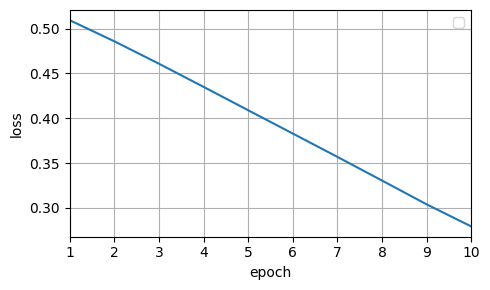

In [39]:
model = NadarayaWatsonRegression()
model = train_NadarayaWatson(model, keys, values, x_train, Epochs=10, lr=0.2)
print("模型拟合得到的核函数超参数：",model.sigma.numpy())

观察模型的预测效果

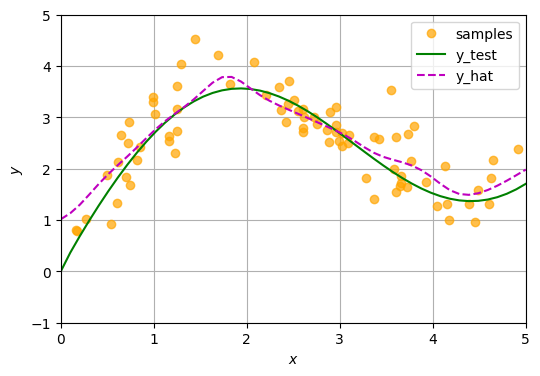

In [40]:
# 预测的时候，就可以使用所有的训练数据作为 key-value 了
n_test = x_test.shape[0]
keys_test = tf.repeat(tf.expand_dims(x_train, axis=0), repeats=n_test, axis=0) # 形状 (n_train, n_train)
values_test = tf.repeat(tf.expand_dims(y_train, axis=0), repeats=n_test, axis=0) # 形状 (n_train, n_train)
y_hat = model(key=keys_test, value=values_test, query=x_test)
# 画图
ch5.plot_kernel_regression(x_train, y_train, x_test, y_test, y_hat)

最后，我们在观察一下在该超参数设置下，**模型在预测时注意力的分布情况**
* 超参数 $\sigma$ 缩小了，模型在**预测每个测试样本时的注意力更集中了**
* 从预测曲线来看，模型的拟合效果更好，误差更小

array([[<Axes: xlabel='Keys: Sorted training $x$', ylabel='Queries: Sorted testing $x$'>]],
      dtype=object)

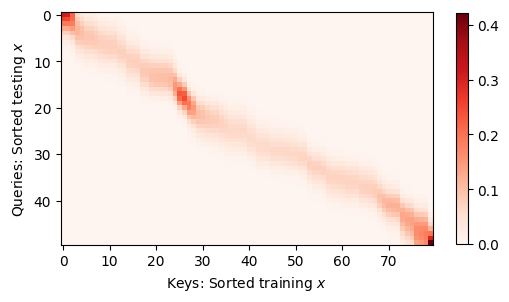

In [41]:
utils.show_attention(
    tf.reshape(model.attn_weights, shape=(1,1,*model.attn_weights.shape)),
    xlabel="Keys: Sorted training $x$", 
    ylabel="Queries: Sorted testing $x$",figsize=(6,5))

----

### **练习**

1. 在我们演示通过梯度下降的求解核函数参数 $\sigma$ 的过程中，训练阶段 `x_train` 同时作为 `query` 和 `key`，对每个训练样本 $x_i$，如果**没有在它可以查找的** `key-value` 中**剔除自身**（即 `key-value` 中包含了 $(x_i,y_i)$），可能会得到什么结果？

1. 此时训练得到的$\sigma$值应该会非常小，趋近于0，因为此时对每个训练样本，它只需要自身一个样本点就能得到很好的预测结果，其他点的权重都会趋于零，从而$\sigma$趋于0

模型拟合得到的核函数超参数： [0.03860812]


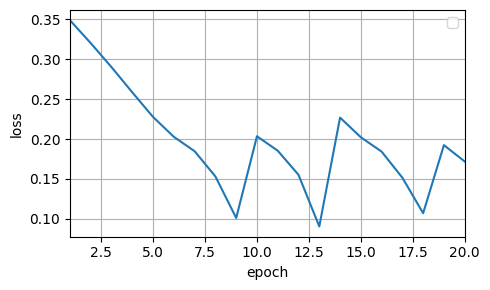

In [47]:
#不删除对角线元素
n_train = x_train.shape[0]
# 将 x_train 作为 key 复制 n_train 次，作为样本
keys = tf.repeat(tf.expand_dims(x_train, axis=0), repeats=n_train, axis=0) # 形状 (n_train, n_train)
# 同理，将 y_train 作为 value 复制 n_train 次
values = tf.repeat(tf.expand_dims(y_train, axis=0), repeats=n_train, axis=0) # 形状 (n_train, n_train)

model = NadarayaWatsonRegression()
model = train_NadarayaWatson(model, keys, values, x_train, Epochs=20, lr=0.2)
print("模型拟合得到的核函数超参数：",model.sigma.numpy())


2. 你能试着**构想在之前我们接触的深度学习模型**和相关任务，例如**图像分类**、**文本预测，机器翻译等**，该如何**引入注意力机制**呢？
    * 想不出来没关系，后面的章节我们会逐步揭晓答案

----